# 01 — ADP1 Database Exploration

Explore the user-provided SQLite database (`user_data/berdl_tables.db`) containing comprehensive data for *Acinetobacter baylyi* ADP1 and related genomes.

**Goals:**
1. Full inventory of all 15 tables — schemas, row counts, NULL coverage
2. Key distributions and value ranges
3. Relationships between tables (shared keys)
4. Identify BERDL connection points (reaction IDs, pangenome clusters, UniRef, COG/KEGG)

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

DB_PATH = Path('../user_data/berdl_tables.db')
conn = sqlite3.connect(DB_PATH)
print(f'Database: {DB_PATH} ({DB_PATH.stat().st_size / 1024 / 1024:.1f} MB)')

Database: ../user_data/berdl_tables.db (135.2 MB)


## 1. Table Inventory

In [2]:
# Get all tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name", conn)
table_names = tables['name'].tolist()

# Build inventory: row count, column count, columns
inventory = []
for t in table_names:
    count = pd.read_sql(f'SELECT COUNT(*) as n FROM "{t}"', conn).iloc[0]['n']
    cols_df = pd.read_sql(f'PRAGMA table_info("{t}")', conn)
    col_names = cols_df['name'].tolist()
    inventory.append({
        'table': t,
        'rows': count,
        'columns': len(col_names),
        'column_names': ', '.join(col_names[:8]) + ('...' if len(col_names) > 8 else ''),
    })

inv_df = pd.DataFrame(inventory)
print(f'Total tables: {len(inv_df)}')
print(f'Total rows: {inv_df["rows"].sum():,}')
print()
inv_df.style.format({'rows': '{:,}'})

Total tables: 15
Total rows: 461,522



,table,rows,columns,column_names
0,gene_essentiality,"3,405",3,"gene_id, essentiality_minimal, essentiality_lb"
1,gene_phenotypes,"239,584",13,"genome_id, gene_id, phenotype_id, phenotype_name, association_sources, model_pred_reactions, model_pred_max_flux, fitness_match..."
2,gene_reaction_data,"12,311",7,"genome_id, gene_id, reaction, rich_media_flux, rich_media_class, minimal_media_flux, minimal_media_class"
3,genome,14,5,"id, gtdb_taxonomy, ncbi_taxonomy, n_contigs, n_features"
4,genome_ani,1,6,"genome1, genome2, ani, af1, af2, kind"
5,genome_features,"5,852",51,"id, genome_id, contig_id, feature_id, length, start, end, strand..."
6,genome_reactions,"17,984",13,"genome_id, reaction_id, genes, equation_names, equation_ids, directionality, upper_bound, lower_bound..."
7,growth_phenotype_summary,573,13,"genome_id, taxonomy, false_positives, false_negatives, true_positives, true_negatives, accuracy, positive_growth..."
8,growth_phenotypes_detailed,"121,519",12,"genome_id, phenotype_id, phenotype_name, class, simulated_objective, observed_objective, gap_count, gapfilled_reactions..."
9,missing_functions,243,7,"Reaction, RAST_function, RichGapfill, MinimalGapfill, PhenotypeGapfill, ModuleGapfill, Pangenome"


## 2. Table Schemas and NULL Coverage

In [3]:
# For each table, compute NULL percentage per column
null_reports = {}

for t in table_names:
    df = pd.read_sql(f'SELECT * FROM "{t}"', conn)
    total = len(df)
    if total == 0:
        continue
    null_pct = (df.isnull().sum() / total * 100).round(1)
    non_null_pct = (100 - null_pct).round(1)
    dtypes = df.dtypes.astype(str)
    
    report = pd.DataFrame({
        'dtype': dtypes,
        'non_null_%': non_null_pct,
        'null_%': null_pct,
        'unique': df.nunique(),
        'sample': df.iloc[0].astype(str).str[:60],
    })
    null_reports[t] = report

# Show the main tables
for t in ['genome', 'genome_features', 'gene_essentiality', 'strains']:
    print(f'\n=== {t} ({inv_df[inv_df.table == t].iloc[0]["rows"]:,} rows) ===')
    display(null_reports[t])


=== genome (14 rows) ===


,dtype,non_null_%,null_%,unique,sample
id,str,100.0,0.0,14,user_Acinetobacter_baylyi_ADP1_RAST
gtdb_taxonomy,str,92.9,7.1,1,NaN
ncbi_taxonomy,object,0.0,100.0,0,NaN
n_contigs,int64,100.0,0.0,13,1
n_features,int64,100.0,0.0,13,3235



=== genome_features (5,852 rows) ===


,dtype,non_null_%,null_%,unique,sample
id,float64,55.3,44.7,3235,0.0
genome_id,str,100.0,0.0,1,user_Acinetobacter_baylyi_ADP1_RAST
contig_id,str,100.0,0.0,4,NC_005966.1
feature_id,str,100.0,0.0,5852,ACIAD_RS16655
length,int64,100.0,0.0,747,135
start,float64,55.3,44.7,3235,3598157.0
end,float64,55.3,44.7,3228,3598022.0
strand,str,55.3,44.7,2,-
sequence,str,54.8,45.2,3197,MKRTFQPSELKRKRVHGFRARMATKAGRQVLARRRAKGRHSLTV
sequence_hash,str,55.3,44.7,3198,7d65c1a20020e525331b75ca22e41542



=== gene_essentiality (3,405 rows) ===


,dtype,non_null_%,null_%,unique,sample
gene_id,str,100.0,0.0,3405,ACIAD_RS00010
essentiality_minimal,str,100.0,0.0,3,essential
essentiality_lb,str,100.0,0.0,3,essential



=== strains (7 rows) ===


,dtype,non_null_%,null_%,unique,sample
database_id,object,0.0,100.0,0,NaN
name,str,100.0,0.0,7,ADP1
strain_construction,str,100.0,0.0,7,Neidle lab wildtype strain of Acinetobacter ba...
genotype,str,100.0,0.0,7,wt
phenotype,str,100.0,0.0,3,wt
description,str,100.0,0.0,7,Neidle ADP1 strain has several mutations relat...
parent_strain,str,85.7,14.3,2,NaN
dgoa_allele,str,85.7,14.3,1,NaN
dgoa_kan_copy_number,str,100.0,0.0,2,0


In [4]:
# Show remaining tables
for t in ['genome_reactions', 'gene_reaction_data', 'gene_phenotypes', 
          'growth_phenotypes_detailed', 'growth_phenotype_summary',
          'missing_functions', 'pan_genome_features']:
    print(f'\n=== {t} ({inv_df[inv_df.table == t].iloc[0]["rows"]:,} rows) ===')
    display(null_reports[t])


=== genome_reactions (17,984 rows) ===


,dtype,non_null_%,null_%,unique,sample
genome_id,str,100.0,0.0,14,RS_GCF_010577925.1
reaction_id,str,100.0,0.0,1330,rxn02201
genes,str,83.0,17.0,7984,NZ_MPVY01000010.1_199 or (NZ_MPVY01000001.1_41...
equation_names,str,100.0,0.0,1330,ABEE [c0] + 2-Amino-4-hydroxy-6-hydroxymethyl-...
equation_ids,str,100.0,0.0,1330,cpd00443_c0 + cpd02920_c0 --> cpd00012_c0 + cp...
directionality,str,100.0,0.0,3,forward
upper_bound,int64,100.0,0.0,3,1000
lower_bound,int64,100.0,0.0,3,0
gapfilling_status,str,100.0,0.0,3,none
rich_media_flux,float64,100.0,0.0,1291,0.0



=== gene_reaction_data (12,311 rows) ===


,dtype,non_null_%,null_%,unique,sample
genome_id,str,100.0,0.0,14,RS_GCF_010577925.1
gene_id,str,100.0,0.0,12311,NZ_MPVY01000001.1_41
reaction,str,100.0,0.0,559,rxn02200;rxn02201;rxn02503
rich_media_flux,float64,100.0,0.0,757,0.0081077660188029
rich_media_class,str,100.0,0.0,3,variable
minimal_media_flux,float64,100.0,0.0,929,0.0006862267035855
minimal_media_class,str,100.0,0.0,3,variable



=== gene_phenotypes (239,584 rows) ===


,dtype,non_null_%,null_%,unique,sample
genome_id,str,100.0,0.0,14,RS_GCF_000368685.1
gene_id,str,100.0,0.0,2670,NZ_KB849627
phenotype_id,str,100.0,0.0,230,cpd00020
phenotype_name,str,100.0,0.0,230,Pyruvic Acid
association_sources,str,100.0,0.0,3,model_prediction
model_pred_reactions,str,77.9,22.1,729,rxn00066;rxn00106;rxn00119;rxn00132;rxn00137;r...
model_pred_max_flux,float64,100.0,0.0,10646,0.022282
fitness_match,str,100.0,0.0,4,no_fitness_ortholog
fitness_max,float64,42.5,57.5,72499,NaN
fitness_min,float64,42.5,57.5,72993,NaN



=== growth_phenotypes_detailed (121,519 rows) ===


,dtype,non_null_%,null_%,unique,sample
genome_id,str,100.0,0.0,574,RS_GCF_000368685.1
phenotype_id,str,100.0,0.0,212,cpd00020
phenotype_name,str,100.0,0.0,212,Pyruvic Acid
class,str,100.0,0.0,6,P
simulated_objective,float64,100.0,0.0,52652,4.257945
observed_objective,int64,100.0,0.0,2,0
gap_count,int64,100.0,0.0,30,0
gapfilled_reactions,str,86.7,13.3,6915,NaN
reaction_count,int64,100.0,0.0,205,393
transports_added,str,14.7,85.3,295,NaN



=== growth_phenotype_summary (573 rows) ===


,dtype,non_null_%,null_%,unique,sample
genome_id,str,100.0,0.0,573,RS_GCF_000368685.1
taxonomy,object,0.0,100.0,0,NaN
false_positives,int64,100.0,0.0,20,0
false_negatives,int64,100.0,0.0,58,0
true_positives,int64,100.0,0.0,29,0
true_negatives,int64,100.0,0.0,81,0
accuracy,float64,100.0,0.0,169,0.0
positive_growth,int64,100.0,0.0,59,19
negative_growth,int64,100.0,0.0,59,193
avg_positive_growth_gaps,int64,100.0,0.0,1,0



=== missing_functions (243 rows) ===


,dtype,non_null_%,null_%,unique,sample
Reaction,str,100.0,0.0,243,rxn05469
RAST_function,str,60.5,39.5,147,Pyruvate [e0] + H+ [e0] <=> Pyruvate [c0] + H+...
RichGapfill,int64,100.0,0.0,2,0
MinimalGapfill,int64,100.0,0.0,2,1
PhenotypeGapfill,int64,100.0,0.0,1,0
ModuleGapfill,int64,100.0,0.0,1,0
Pangenome,int64,100.0,0.0,2,0



=== pan_genome_features (43,754 rows) ===


,dtype,non_null_%,null_%,unique,sample
id,int64,100.0,0.0,43754,0
genome_id,str,100.0,0.0,13,GB_GCA_002694305.1
contig_id,str,100.0,0.0,892,NZLS01000001.1
feature_id,str,100.0,0.0,43754,NZLS01000001.1_1
length,int64,100.0,0.0,846,903
start,int64,100.0,0.0,37432,17
end,int64,100.0,0.0,37733,922
strand,object,0.0,100.0,0,NaN
sequence,str,100.0,0.0,7761,MTLLDASIWNKKLFNGGWFESGQPYGVVEVATGEQLGQTGSASPTD...
sequence_hash,str,100.0,0.0,7761,1cc09b1786df92860b855598d21fba70


## 3. Genome Overview

What genomes are in this database?

In [5]:
genomes = pd.read_sql('SELECT * FROM genome', conn)
print(f'{len(genomes)} genomes in database:\n')
display(genomes[['id', 'gtdb_taxonomy', 'n_contigs', 'n_features']])

14 genomes in database:



,id,gtdb_taxonomy,n_contigs,n_features
0,user_Acinetobacter_baylyi_ADP1_RAST,NaN,1,3235
1,GB_GCA_002694305.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,168,3617
2,RS_GCF_000046845.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,1,3273
3,RS_GCF_000302115.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,95,3465
4,RS_GCF_000368685.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,10,3275
5,RS_GCF_000621045.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,27,3318
6,RS_GCF_001485005.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,34,3311
7,RS_GCF_010577805.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,73,3285
8,RS_GCF_010577855.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,71,3276
9,RS_GCF_010577875.1,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,90,3292


In [6]:
# How many features per genome?
features_per_genome = pd.read_sql(
    'SELECT genome_id, COUNT(*) as n_features FROM genome_features GROUP BY genome_id ORDER BY n_features DESC',
    conn
)
print('Features per genome (genome_features table):')
display(features_per_genome)

print(f'\nNote: genome_features has {features_per_genome.n_features.sum():,} total features')
print(f'pan_genome_features has {inv_df[inv_df.table == "pan_genome_features"].iloc[0]["rows"]:,} total features')

Features per genome (genome_features table):


,genome_id,n_features
0,user_Acinetobacter_baylyi_ADP1_RAST,5852



Note: genome_features has 5,852 total features
pan_genome_features has 43,754 total features


## 4. Gene Features Deep Dive

The `genome_features` table is the richest — 51 columns covering annotations, metabolic flux, essentiality, proteomics, and growth phenotypes.

In [7]:
gf = pd.read_sql('SELECT * FROM genome_features', conn)
print(f'genome_features: {len(gf):,} rows, {len(gf.columns)} columns')
print(f'Genome: {gf.genome_id.unique()[0]}')
print()

# Group columns by category
annotation_cols = ['bakta_function', 'rast_function', 'cog', 'ec', 'gene_names', 
                   'go', 'ko', 'pfam', 'so', 'uniref_100', 'uniref_90', 'uniref_50']
pangenome_cols = ['pangenome_cluster_id', 'pangenome_is_core']
metabolic_cols = ['reactions', 'rich_media_flux', 'rich_media_class', 
                  'minimal_media_flux', 'minimal_media_class']
essentiality_cols = ['essentiality_minimal', 'essentiality_lb']
proteomics_cols = [c for c in gf.columns if c.startswith('proteomics_')]
growth_cols = [c for c in gf.columns if c.startswith('mutant_growth_')]

# Coverage per category
categories = {
    'Annotation': annotation_cols,
    'Pangenome': pangenome_cols,
    'Metabolic model': metabolic_cols,
    'Essentiality': essentiality_cols,
    'Proteomics': proteomics_cols,
    'Mutant growth': growth_cols,
}

print('Coverage by category (% of genes with non-null values):')
print(f'{"Category":<20} {"Columns":<10} {"Avg coverage":<15}')
print('-' * 45)
for cat, cols in categories.items():
    existing = [c for c in cols if c in gf.columns]
    if existing:
        avg_cov = gf[existing].notna().mean().mean() * 100
        print(f'{cat:<20} {len(existing):<10} {avg_cov:.1f}%')

genome_features: 5,852 rows, 51 columns
Genome: user_Acinetobacter_baylyi_ADP1_RAST

Coverage by category (% of genes with non-null values):
Category             Columns    Avg coverage   
---------------------------------------------
Annotation           12         40.2%
Pangenome            2          54.5%
Metabolic model      5          14.8%
Essentiality         2          58.2%
Proteomics           8          40.7%
Mutant growth        8          39.1%


In [8]:
# Annotation coverage detail
print('Annotation coverage per column:')
for col in annotation_cols:
    if col in gf.columns:
        non_null = gf[col].notna().sum()
        unique = gf[col].nunique()
        print(f'  {col:<25} {non_null:>5}/{len(gf)} ({non_null/len(gf)*100:.1f}%)  {unique:>5} unique')

Annotation coverage per column:
  bakta_function             3209/5852 (54.8%)   2399 unique
  rast_function              3235/5852 (55.3%)   2295 unique
  cog                         354/5852 (6.0%)    332 unique
  ec                         1080/5852 (18.5%)    803 unique
  gene_names                 1347/5852 (23.0%)   1192 unique
  go                         1009/5852 (17.2%)    895 unique
  ko                         1984/5852 (33.9%)   1665 unique
  pfam                       3235/5852 (55.3%)   1795 unique
  so                         3218/5852 (55.0%)   1894 unique
  uniref_100                 3128/5852 (53.5%)   3117 unique
  uniref_90                  3204/5852 (54.8%)   3187 unique
  uniref_50                  3201/5852 (54.7%)   3153 unique


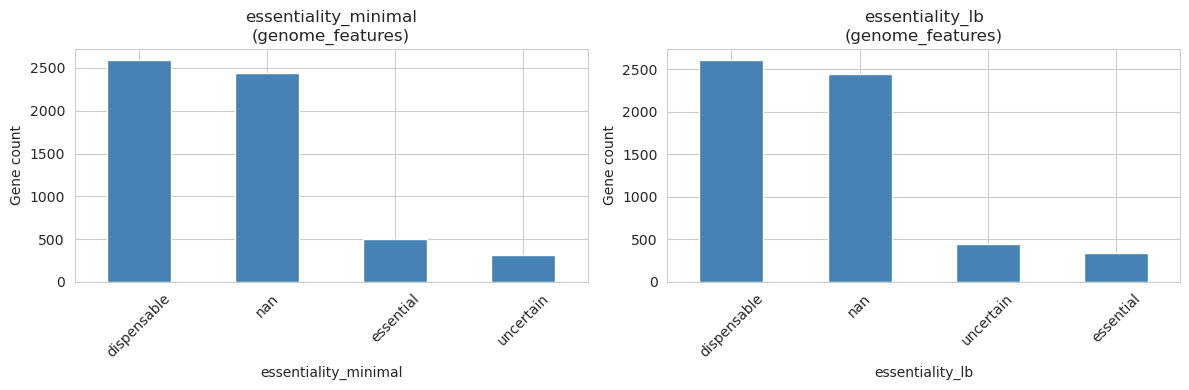

Saved: figures/essentiality_distribution.png


In [9]:
# Essentiality distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(['essentiality_minimal', 'essentiality_lb']):
    counts = gf[col].value_counts(dropna=False)
    counts.plot.bar(ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col}\n(genome_features)')
    axes[i].set_ylabel('Gene count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/essentiality_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/essentiality_distribution.png')

In [10]:
# Core vs accessory gene distribution
core_counts = gf['pangenome_is_core'].value_counts(dropna=False)
print('Pangenome core/accessory (genome_features):')
for val, count in core_counts.items():
    label = 'Core' if val == 1 else ('Accessory' if val == 0 else 'Unknown')
    print(f'  {label}: {count:,} ({count/len(gf)*100:.1f}%)')

Pangenome core/accessory (genome_features):
  Core: 2,957 (50.5%)
  Unknown: 2,665 (45.5%)
  Accessory: 230 (3.9%)


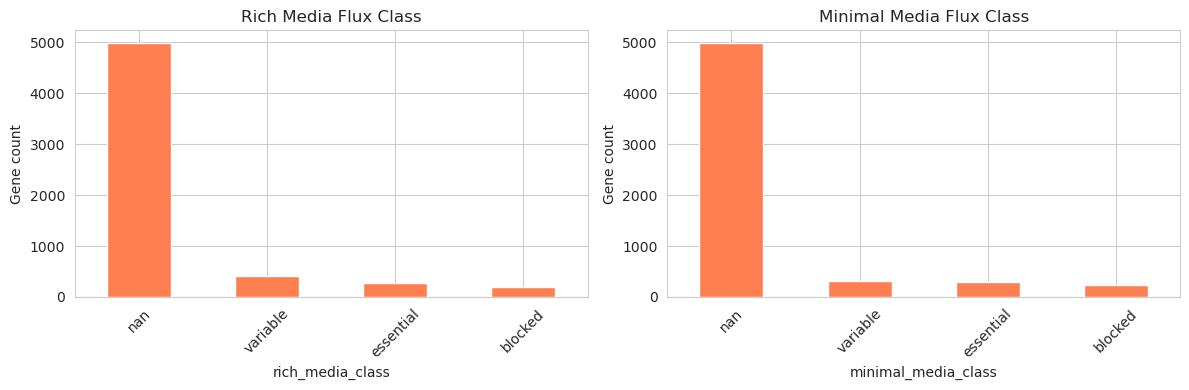

Saved: figures/metabolic_flux_classes.png


In [11]:
# Metabolic flux distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (flux_col, class_col, title) in enumerate([
    ('rich_media_flux', 'rich_media_class', 'Rich Media'),
    ('minimal_media_flux', 'minimal_media_class', 'Minimal Media'),
]):
    # Flux class distribution
    class_counts = gf[class_col].value_counts(dropna=False)
    class_counts.plot.bar(ax=axes[i], color='coral')
    axes[i].set_title(f'{title} Flux Class')
    axes[i].set_ylabel('Gene count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/metabolic_flux_classes.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/metabolic_flux_classes.png')

Mutant growth data coverage:
  acetate               2279 genes (38.9%)
  asparagine            2312 genes (39.5%)
  butanediol            2300 genes (39.3%)
  glucarate             2222 genes (38.0%)
  glucose               2251 genes (38.5%)
  lactate               2316 genes (39.6%)
  quinate               2310 genes (39.5%)
  urea                  2312 genes (39.5%)


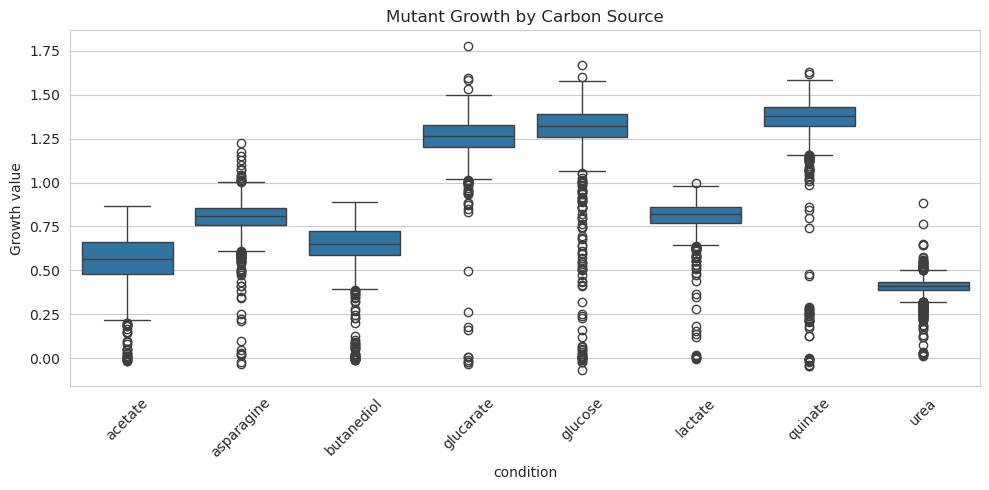

Saved: figures/mutant_growth_by_condition.png


In [12]:
# Mutant growth data availability
growth_cols_actual = [c for c in gf.columns if c.startswith('mutant_growth_')]
if growth_cols_actual:
    growth_coverage = gf[growth_cols_actual].notna().sum()
    print('Mutant growth data coverage:')
    for col in growth_cols_actual:
        n = gf[col].notna().sum()
        condition = col.replace('mutant_growth_', '')
        print(f'  {condition:<20} {n:>5} genes ({n/len(gf)*100:.1f}%)')
    
    # Distribution of growth values for genes that have data
    fig, ax = plt.subplots(figsize=(10, 5))
    growth_data = gf[growth_cols_actual].melt(var_name='condition', value_name='growth')
    growth_data['condition'] = growth_data['condition'].str.replace('mutant_growth_', '')
    growth_data = growth_data.dropna()
    
    if len(growth_data) > 0:
        sns.boxplot(data=growth_data, x='condition', y='growth', ax=ax)
        ax.set_title('Mutant Growth by Carbon Source')
        ax.set_ylabel('Growth value')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.savefig('../figures/mutant_growth_by_condition.png', dpi=150, bbox_inches='tight')
        plt.show()
        print('Saved: figures/mutant_growth_by_condition.png')
    else:
        print('No mutant growth data values found.')
else:
    print('No mutant_growth columns found.')

## 5. Metabolic Model

The `genome_reactions` table contains FBA model reactions.

In [13]:
rxns = pd.read_sql('SELECT * FROM genome_reactions', conn)
print(f'Total reactions: {len(rxns):,}')
print(f'Genomes with reactions: {rxns.genome_id.nunique()}')
print(f'Unique reaction IDs: {rxns.reaction_id.nunique()}')
print()

# Reactions per genome
rxn_per_genome = rxns.groupby('genome_id').size().reset_index(name='n_reactions')
print('Reactions per genome:')
display(rxn_per_genome.sort_values('n_reactions', ascending=False))

print(f'\nGapfilling status:')
print(rxns.gapfilling_status.value_counts())

Total reactions: 17,984
Genomes with reactions: 14
Unique reaction IDs: 1330

Reactions per genome:


,genome_id,n_reactions
8,RS_GCF_010577875.1,1291
9,RS_GCF_010577895.1,1291
2,RS_GCF_000302115.1,1286
10,RS_GCF_010577925.1,1286
11,RS_GCF_010577955.1,1285
0,GB_GCA_002694305.1,1284
6,RS_GCF_010577805.1,1284
7,RS_GCF_010577855.1,1284
3,RS_GCF_000368685.1,1284
1,RS_GCF_000046845.1,1284



Gapfilling status:
gapfilling_status
none       16606
rich         811
minimal      567
Name: count, dtype: int64


In [14]:
# Rich media flux class distribution
print('Rich media flux classes (across all genomes):')
print(rxns.rich_media_class.value_counts())
print()
print('Minimal media flux classes:')
print(rxns.minimal_media_class.value_counts())

Rich media flux classes (across all genomes):
rich_media_class
blocked              7196
forward_only         3797
essential_forward    2549
reversible           2400
reverse_only         1117
essential_reverse     925
Name: count, dtype: int64

Minimal media flux classes:
minimal_media_class
blocked              8154
forward_only         4205
essential_forward    2322
reverse_only         1328
essential_reverse     997
reversible            978
Name: count, dtype: int64


## 6. Gene Phenotypes

In [15]:
pheno = pd.read_sql('SELECT * FROM gene_phenotypes', conn)
print(f'Gene-phenotype associations: {len(pheno):,}')
print(f'Unique genes: {pheno.gene_id.nunique():,}')
print(f'Unique phenotypes: {pheno.phenotype_id.nunique()}')
print(f'Genomes: {pheno.genome_id.nunique()}')
print()

# Association sources
print('Association sources:')
print(pheno.association_sources.value_counts())
print()

# Fitness match categories
print('Fitness match categories:')
print(pheno.fitness_match.value_counts())

Gene-phenotype associations: 239,584
Unique genes: 2,670
Unique phenotypes: 230
Genomes: 14

Association sources:
association_sources
model_prediction            147114
fitness                      75777
fitness;model_prediction     16693
Name: count, dtype: int64

Fitness match categories:
fitness_match
has_score                        101853
no_fitness_data_for_phenotype     73887
no_fitness_ortholog               51193
no_score_for_gene_phenotype       12651
Name: count, dtype: int64


In [16]:
# Top phenotypes by gene count
top_pheno = pheno.groupby('phenotype_name').size().sort_values(ascending=False).head(20)
print('Top 20 phenotypes by gene association count:')
for name, count in top_pheno.items():
    print(f'  {name:<40} {count:>6}')

Top 20 phenotypes by gene association count:
  L Lactic Acid                              2161
  D Glucose                                  2155
  a Keto Glutaric Acid                       1972
  Pyruvic Acid                               1954
  D L Malic Acid                             1947
  Succinic Acid                              1935
  Sucrose                                    1903
  Acetic Acid                                1860
  Glycerol                                   1846
  L Glutamine                                1842
  Propionic Acid                             1837
  D Fructose                                 1834
  D Galactose                                1792
  D Gluconic Acid                            1783
  N Acetyl D Glucosamine                     1764
  L Alanine                                  1761
  D Xylose                                   1752
  D Mannose                                  1746
  D Trehalose                                1745
  L A

## 7. Growth Phenotype Simulations

In [17]:
growth_detail = pd.read_sql('SELECT * FROM growth_phenotypes_detailed', conn)
growth_summary = pd.read_sql('SELECT * FROM growth_phenotype_summary', conn)

print(f'Growth phenotype predictions: {len(growth_detail):,}')
print(f'Summary entries: {len(growth_summary)}')
print()

# Accuracy summary
print('Model accuracy by genome:')
display(growth_summary[['genome_id', 'accuracy', 'true_positives', 'true_negatives', 
                         'false_positives', 'false_negatives']].head(10))

Growth phenotype predictions: 121,519
Summary entries: 573

Model accuracy by genome:


,genome_id,accuracy,true_positives,true_negatives,false_positives,false_negatives
0,RS_GCF_000368685.1,0.0,0,0,0,0
1,RS_GCF_010577805.1,0.0,0,0,0,0
2,RS_GCF_010577875.1,0.0,0,0,0,0
3,RS_GCF_000046845.1,0.0,0,0,0,0
4,RS_GCF_000302115.1,0.0,0,0,0,0
5,GB_GCA_002694305.1,0.0,0,0,0,0
6,RS_GCF_000621045.1,0.0,0,0,0,0
7,RS_GCF_010577855.1,0.0,0,0,0,0
8,RS_GCF_001485005.1,0.0,0,0,0,0
9,RS_GCF_010577895.1,0.0,0,0,0,0


In [18]:
# Prediction class distribution
print('Prediction classes (detailed):')
print(growth_detail['class'].value_counts())

Prediction classes (detailed):
class
N     86516
CN    12636
P     10065
FN     6650
CP     3837
FP     1772
Name: count, dtype: int64


## 8. Ontology Data

In [19]:
ont_defs = pd.read_sql('SELECT * FROM ontology_definitions', conn)
ont_terms = pd.read_sql('SELECT * FROM ontology_terms', conn)
ont_rels = pd.read_sql('SELECT * FROM ontology_relationships', conn)

print('Ontology prefixes:')
display(ont_defs)
print(f'\nOntology terms: {len(ont_terms):,}')
print(f'Ontology relationships: {len(ont_rels):,}')
print()
print('Terms per prefix:')
print(ont_terms.groupby('ontology_prefix').size().sort_values(ascending=False))

Ontology prefixes:


,ontology_prefix,definition
0,GO,Gene Ontology - standardized vocabulary for ge...
1,EC,Enzyme Commission numbers - classification of ...
2,SO,Sequence Ontology - vocabulary for sequence fe...
3,PFAM,Protein Families database - protein domain fam...
4,KEGG,KEGG Orthologs - ortholog groups linking genes...
5,COG,Clusters of Orthologous Groups - protein funct...
6,seed.role,SEED Role Ontology - functional roles from RAS...
7,seed.reaction,SEED Reaction Ontology - biochemical reactions...



Ontology terms: 11,539
Ontology relationships: 4,728

Terms per prefix:
ontology_prefix
seed.role        2256
PFAM             1937
SO               1889
KEGG             1790
GO               1423
seed.reaction     990
EC                909
COG               345
dtype: int64


## 9. Strains

In [20]:
strains = pd.read_sql('SELECT * FROM strains', conn)
print(f'Strains: {len(strains)}')
display(strains)

Strains: 7


,database_id,name,strain_construction,genotype,phenotype,description,parent_strain,dgoa_allele,dgoa_kan_copy_number
0,None,ADP1,Neidle lab wildtype strain of Acinetobacter ba...,wt,wt,Neidle ADP1 strain has several mutations relat...,NaN,NaN,0
1,None,ACN2821,EASy isolate from population ACN2676 (pBAC1414...,"ΔaroF52544, ΔaroG52417, dgoA52586, KmR52586, f...",Grows without the aromatic amino acids,"Streak purified EASy isolate, single copy of d...",ACN2586,Star,1
2,None,ACN2586,pBAC1837 linearized (AatII) X ACN2567,"ΔaroF52544, ΔaroG52417, dgoA*-KmR inserted bet...","Grows slowly without the aromatic amino acids,...","ADP1 has two native DAHP synthase genes, ACIAD...",ACN2567,Star,1
3,None,ACN3425,Streak purified strain from a transformation w...,"ΔaroF52544, ΔaroG52417; dgoA52586; KmR52586; ...",Grows without the aromatic amino acids,Streak purified strain from a transformation w...,ACN2586,Star,1
4,None,ACN3427,Streak purified strain from a transformation w...,"ΔaroF52544, ΔaroG52417; dgoA52586; KmR52586; ...",Grows without the aromatic amino acids,Streak purified strain from a transformation w...,ACN2586,Star,1
5,None,ACN3429,Streak purified strain from a transformation w...,"ΔaroF52544, ΔaroG52417; dgoA52586; KmR52586; ...",Grows without the aromatic amino acids,Streak purified strain from a transformation w...,ACN2586,Star,1
6,None,ACN3430,Streak purified strain from a transformation w...,"ΔaroF52544, ΔaroG52417; dgoA52586; KmR52586; ...",Grows without the aromatic amino acids,Streak purified strain from a transformation w...,ACN2586,Star,1


## 10. BERDL Connection Points

Identify identifiers in the ADP1 database that can link to BERDL collections.

In [21]:
# Collect all linkable identifiers
connections = {}

# 1. Reaction IDs -> kbase_msd_biochemistry
rxn_ids = rxns['reaction_id'].unique()
connections['ModelSEED Reactions'] = {
    'count': len(rxn_ids),
    'berdl_collection': 'kbase_msd_biochemistry.reaction',
    'sample': list(rxn_ids[:5]),
    'format': 'rxnNNNNN',
}

# 2. Genome IDs (GCF/GCA format) -> kbase_ke_pangenome.genome
genome_ids = genomes['id'].tolist()
berdl_genome_ids = [g for g in genome_ids if g.startswith(('RS_GCF_', 'GB_GCA_'))]
connections['BERDL Genome IDs'] = {
    'count': len(berdl_genome_ids),
    'berdl_collection': 'kbase_ke_pangenome.genome',
    'sample': berdl_genome_ids[:5],
    'format': 'RS_GCF_*/GB_GCA_*',
}

# 3. Pangenome cluster IDs -> kbase_ke_pangenome.gene_cluster
cluster_ids = gf['pangenome_cluster_id'].dropna().unique()
connections['Pangenome Clusters'] = {
    'count': len(cluster_ids),
    'berdl_collection': 'kbase_ke_pangenome.gene_cluster',
    'sample': list(cluster_ids[:5]),
    'format': 'PREFIX_mmseqsCluster_NNNN',
}

# 4. UniRef IDs
for uniref_col, berdl_db in [('uniref_50', 'kbase_uniref50'), 
                               ('uniref_90', 'kbase_uniref90'),
                               ('uniref_100', 'kbase_uniref100')]:
    ids = gf[uniref_col].dropna().unique()
    connections[f'UniRef ({uniref_col})'] = {
        'count': len(ids),
        'berdl_collection': berdl_db,
        'sample': list(ids[:3]),
        'format': 'UniRefNN_*',
    }

# 5. COG IDs -> eggnog_mapper_annotations
cog_ids = gf['cog'].dropna().unique()
connections['COG IDs'] = {
    'count': len(cog_ids),
    'berdl_collection': 'kbase_ke_pangenome.eggnog_mapper_annotations (COG_category)',
    'sample': list(cog_ids[:5]),
    'format': 'COGNNNN',
}

# 6. KEGG KO -> eggnog_mapper_annotations  
ko_ids = gf['ko'].dropna().unique()
connections['KEGG KO'] = {
    'count': len(ko_ids),
    'berdl_collection': 'kbase_ke_pangenome.eggnog_mapper_annotations (KEGG_ko)',
    'sample': list(ko_ids[:5]),
    'format': 'KNNNN',
}

# 7. EC numbers -> biochemistry
ec_ids = gf['ec'].dropna().unique()
connections['EC Numbers'] = {
    'count': len(ec_ids),
    'berdl_collection': 'kbase_msd_biochemistry (via EC)',
    'sample': list(ec_ids[:5]),
    'format': 'N.N.N.N',
}

# 8. Pfam -> eggnog_mapper_annotations
pfam_ids = gf['pfam'].dropna().unique()
connections['Pfam'] = {
    'count': len(pfam_ids),
    'berdl_collection': 'kbase_ke_pangenome.eggnog_mapper_annotations (PFAMs)',
    'sample': list(pfam_ids[:3]),
    'format': 'PFNNNNN',
}

# 9. Phenotype compound IDs -> biochemistry
cpd_ids = pheno['phenotype_id'].unique()
cpd_ids_modelseed = [c for c in cpd_ids if c.startswith('cpd')]
connections['Phenotype Compounds'] = {
    'count': len(cpd_ids_modelseed),
    'berdl_collection': 'kbase_msd_biochemistry.compound',
    'sample': cpd_ids_modelseed[:5],
    'format': 'cpdNNNNN',
}

print(f'BERDL Connection Points Found: {len(connections)}\n')
print(f'{"Identifier Type":<25} {"Count":<10} {"BERDL Target":<55} {"Sample"}')
print('-' * 130)
for name, info in connections.items():
    sample_str = str(info['sample'][:3])
    if len(sample_str) > 40:
        sample_str = sample_str[:40] + '...'
    print(f'{name:<25} {info["count"]:<10} {info["berdl_collection"]:<55} {sample_str}')

BERDL Connection Points Found: 11

Identifier Type           Count      BERDL Target                                            Sample
----------------------------------------------------------------------------------------------------------------------------------
ModelSEED Reactions       1330       kbase_msd_biochemistry.reaction                         ['rxn02201', 'rxn00351', 'rxn00836']
BERDL Genome IDs          13         kbase_ke_pangenome.genome                               ['GB_GCA_002694305.1', 'RS_GCF_000046845...
Pangenome Clusters        2538       kbase_ke_pangenome.gene_cluster                         ['NHSXFYEX_mmseqsCluster_0450', 'NHSXFYE...
UniRef (uniref_50)        3153       kbase_uniref50                                          ['UniRef50_Q6F6K7', 'UniRef50_Q6F6K8', '...
UniRef (uniref_90)        3187       kbase_uniref90                                          ['UniRef90_Q6F6K7', 'UniRef90_Q6F6K8', '...
UniRef (uniref_100)       3117       kbase_uniref100    

## 11. Table Relationship Map

How do the tables connect to each other?

In [22]:
# Identify shared columns across tables
all_columns = {}
for t in table_names:
    cols = pd.read_sql(f'PRAGMA table_info("{t}")', conn)['name'].tolist()
    all_columns[t] = set(cols)

# Find shared columns between table pairs
print('Table relationships (shared columns):\n')
relationships = []
for i, t1 in enumerate(table_names):
    for t2 in table_names[i+1:]:
        shared = all_columns[t1] & all_columns[t2]
        # Filter out generic columns
        meaningful = shared - {'id', 'name', 'description', 'label', 'definition'}
        if meaningful:
            relationships.append((t1, t2, meaningful))
            print(f'  {t1} <-> {t2}')
            print(f'    via: {sorted(meaningful)}')

print(f'\nTotal relationship pairs: {len(relationships)}')

Table relationships (shared columns):

  gene_essentiality <-> gene_phenotypes
    via: ['gene_id']
  gene_essentiality <-> gene_reaction_data
    via: ['gene_id']
  gene_essentiality <-> genome_features
    via: ['essentiality_lb', 'essentiality_minimal']
  gene_phenotypes <-> gene_reaction_data
    via: ['gene_id', 'genome_id']
  gene_phenotypes <-> genome_features
    via: ['genome_id']
  gene_phenotypes <-> genome_reactions
    via: ['genome_id']
  gene_phenotypes <-> growth_phenotype_summary
    via: ['genome_id']
  gene_phenotypes <-> growth_phenotypes_detailed
    via: ['genome_id', 'phenotype_id', 'phenotype_name']
  gene_phenotypes <-> pan_genome_features
    via: ['genome_id']
  gene_reaction_data <-> genome_features
    via: ['genome_id', 'minimal_media_class', 'minimal_media_flux', 'rich_media_class', 'rich_media_flux']
  gene_reaction_data <-> genome_reactions
    via: ['genome_id', 'minimal_media_class', 'minimal_media_flux', 'rich_media_class', 'rich_media_flux']
  gene_

## 12. Summary

Key findings from the database exploration.

In [23]:
print('=== ADP1 Database Summary ===')
print(f'Database size: {DB_PATH.stat().st_size / 1024 / 1024:.1f} MB')
print(f'Tables: {len(table_names)}')
print(f'Total rows: {inv_df["rows"].sum():,}')
print()

print('Key data:')
print(f'  Genomes: {len(genomes)} (1 user-annotated ADP1 + {len(berdl_genome_ids)} BERDL-linked)')
print(f'  Gene features: {len(gf):,} with {len(gf.columns)} annotation columns')
print(f'  Pangenome features: {inv_df[inv_df.table=="pan_genome_features"].iloc[0]["rows"]:,} across {genomes.shape[0]} genomes')
print(f'  Metabolic reactions: {rxns.reaction_id.nunique():,} unique')
print(f'  Gene-phenotype links: {len(pheno):,}')
print(f'  Essentiality calls: {len(pd.read_sql("SELECT * FROM gene_essentiality", conn)):,} genes')
print()

print('BERDL connection points:')
for name, info in connections.items():
    print(f'  {name}: {info["count"]} identifiers -> {info["berdl_collection"]}')

conn.close()
print('\nDatabase connection closed.')

=== ADP1 Database Summary ===
Database size: 135.2 MB
Tables: 15
Total rows: 461,522

Key data:
  Genomes: 14 (1 user-annotated ADP1 + 13 BERDL-linked)
  Gene features: 5,852 with 51 annotation columns
  Pangenome features: 43,754 across 14 genomes
  Metabolic reactions: 1,330 unique
  Gene-phenotype links: 239,584
  Essentiality calls: 3,405 genes

BERDL connection points:
  ModelSEED Reactions: 1330 identifiers -> kbase_msd_biochemistry.reaction
  BERDL Genome IDs: 13 identifiers -> kbase_ke_pangenome.genome
  Pangenome Clusters: 2538 identifiers -> kbase_ke_pangenome.gene_cluster
  UniRef (uniref_50): 3153 identifiers -> kbase_uniref50
  UniRef (uniref_90): 3187 identifiers -> kbase_uniref90
  UniRef (uniref_100): 3117 identifiers -> kbase_uniref100
  COG IDs: 332 identifiers -> kbase_ke_pangenome.eggnog_mapper_annotations (COG_category)
  KEGG KO: 1665 identifiers -> kbase_ke_pangenome.eggnog_mapper_annotations (KEGG_ko)
  EC Numbers: 803 identifiers -> kbase_msd_biochemistry (via 